# FFNN: Single layer example 

In [ ]:
import numpy as np
def init(dims):
    # We initalize the weights in this case I use where there are a input layer x layer z and output y,
    # so z+y weights to initalize. The initalized are scale for input, so its variance scaled correctly.
    
    # INPUT: Dimesnion of the single layer network
    # OUTPUT: Initalized weight matrix, with each column is a weight fx x->z.
    
    x,z,y=dims
    w = np.sqrt(1/(x+1))
    W = []
    W.append(w*np.random.randn(x+1,z))
    w = np.sqrt(1/(z+1))
    W.append(w*np.random.randn(z+1,y))
    return W

def forward(X, W, n):
    # INPUT: X: Training data, W: Weight matrix, n: points used for training. 
    # OUTPUT: y: Outbut of FFNN, h: a, activation for hidden layer.  
    
    # A fully connected neural network with a_1=max(0,z) (ReLU) as acitvation func and y_out=a_out=softmax(y)
    
    # Look only at subsection of data ( a bit too simple, but for example sake)
    x = X[:,0:n]
    x.shape
    x = np.vstack((x, np.ones((1,n))))
    x.shape

    # % FFNN
    # First layer
    z = W[0].T@x
    h = np.maximum(0, z)
    
    # Second layer
    y_hat = W[1].T@np.vstack((h, np.ones((1,n))))
    y = np.exp(y_hat)/(np.exp(y_hat).sum(axis=0))
    
    return y, h

def backward(X, T, W, n,lr):
    # INPUT: X: Data, T: training sta, W: weights, n: nr trainings points, lr: Learning rate
    
    # Perfom foreward 
    y, h = forward(X, W, n)
    
    
    x = X[:,0:n]
    x.shape
    x = np.vstack((x, np.ones((1,n))))
    x.shape

    delta2=y-T[:,0:n] # Very simple error function of error = model - true = delta2(y)
    Q2=np.vstack((h, np.ones((1,n))))@delta2.T  # dE/d W^2 = h * delta_2 
    W_hat=W[1]                                  # Weight from input layer W^1
    W_hat=W_hat[:-1,:]                          # Remove bias weight from W^1
    a_m=np.where(h > 0, 1, 0)                   # Defin the derivativ of ReLU a'=ReLu'
    delta1=a_m*(W_hat@delta2)                   # delta_1=a'*(W^1*delta_2)
    Q1=x@delta1.T                               # dE/dW^1 = x * delta_1
    
    #Gradient Decent 
    W[0]=W[0]-lr*Q1
    W[1]=W[1]-lr*Q2
    print(f'loop {i}')
    return W

def train(X, T, dims, epochs, lr, batchsize=1):

    # Train the 2-layer network using mini-batch gradient descent.
    
    # INPUT: X : Training input data, T : Target, dims : (x, z, y) layer size, epochs : Number of epochs
    #        lr : Learning rate, batchsize :  Size of mini-batch
            
    # OUTPUT: W : Trained weights,  losses :Loss at each epoch
 
    
    rg = np.random.default_rng()
    W = init(dims)
    losses = []
    m = X.shape[1]
    
    for e in range(epochs):
        order = rg.permutation(m)
        epoch_loss = 0
        
        for k in range(0, m, batchsize):
            batch = order[k:k + batchsize]
            X_batch = X[:, batch]
            T_batch = T[:, batch]
            W, loss = backward(X_batch, T_batch, W, n=batchsize, lr=lr)
            epoch_loss += loss
            
        losses.append(epoch_loss)
        print(f"Epoch {e+1}, loss {epoch_loss:.4f}")
    
    return W, losses

# FFNN: Multilayer 

In [ ]:
import numpy as np



rg = np.random.default_rng() # random munber generator 

def init(dims):
    """
    Initialize weights for a multi-layer feedforward neural network.
    
    INPUT:
        dims : Layer dimensions [input, hidden1, hidden2, ..., output]
    
    OUTPUT:
        W : List of weight matrices for each layer.
            Each W[l] has shape (dims[l]+1, dims[l+1]) and includes bias weights.
    """
    
    W = []
    for l in range(len(dims) - 1):
        
        # initialization for ReLU layers: variance = 2 / fan_in, makes sure variance is stable for relu 
        fan_in = dims[l] + 1
        scale = np.sqrt(2 / fan_in)
        W.append(scale * rg.standard_normal(size=(fan_in, dims[l+1])))
        
    return W


def forward(X, W):
    """
    Perform the forward pass through all layers.
    
    INPUT:
        X : Input data (shape: features × samples)
        W : Weight matrices for each layer
    
    OUTPUT:
        y : Output of forward with softmax aplied
        h : List containing activations (hidden layers and final output pre-softmax)
    """
    
    h = []  # store activations of each layer
    a = X   # input layer
    
    # Forward through hidden layers
    for l in range(len(W) - 1):
        # Add bias term
        a = np.vstack((a, np.ones((1, a.shape[1]))))
        
        # Linear transform
        z = W[l].T @ a
        
        # ReLU activation
        a = np.maximum(0, z)
        h.append(a)
    
    # Output layer (no ReLU, only linear before softmax)
    a = np.vstack((a, np.ones((1, a.shape[1]))))
    y_hat = W[-1].T @ a
    h.append(y_hat)
    
    # Last element in h is pre-softmax output
    y_hat = h[-1]
    
    # Numerically stable softmax
    exp_y = np.exp(y_hat - np.max(y_hat, axis=0))
    y = exp_y / exp_y.sum(axis=0)
    
    return y, h


#################### Connies code ########################
def backward(X, T, W, lr):
    """
    Perform one backward pass and update weights.
    
    INPUT:
        X : Input data (features × samples)
        T : Target labels (one-hot encoded)
        W : Current weight matrices
        lr : Learning rate
    
    OUTPUT:
        W : Updated weight matrices
        loss : Total loss for this batch
    """
    
    n = X.shape[1]
    y, h = forward(X, W)

    # --- Loss ---
    loss = -np.sum(T * np.log(y + 1e-15)) # cross-entropy loss for multi-class classification
    
    # --- Backpropagation --- (Like in example above just more layers)
    delta = y - T  # output layer error (simple example)
    
    # --- First layer update ---
    x_bias = np.vstack((X, np.ones((1, n))))
    Q0 = x_bias @ delta.T
    W[0] -= (lr / n) * Q0
    
    # --- Update all other layers
    
    for l in range(len(W) - 1, 0, -1):
        # Get hidden activation for this layer
        h_l = h[l-1] if l-1 >= 0 else X
        
        # Add bias term
        h_l = np.vstack((h_l, np.ones((1, h_l.shape[1]))))
        
        # Compute gradient for this layer
        Q = h_l @ delta.T
        
        # Update weights
        W[l] -= (lr / n) * Q
        
        # Backpropagate error to previous layer
        W_hat = W[l][:-1, :]  # remove bias weights
        
        if l > 0: # compute delta for next layer
            a_prime = (h[l-1] > 0).astype(float)  # ReLU derivative
            delta = a_prime * (W_hat @ delta)
    
    return W, loss


def train(X, T, W, epochs, lr, batchsize=1):
    """
    Train the multi-layer neural network using gradient descent.
    
    INPUT:
        X : Input data (features × samples)
        T : Target one-hot labels (classes × samples)
        W : Initialized weight matrices
        epochs :  Number of training epochs
        lr : Learning rate
        batchsize : Size of each training batch
    
    OUTPUT:
        W : Trained weight matrices
        losses : Total loss for each epoch
    """
    
    m = X.shape[1]
    losses = []
    
    for e in range(epochs):
        order = rg.permutation(m) # mini-batch is drawn in a random order
        epoch_loss = 0
        
        for k in range(0, m, batchsize):
            batch = order[k:k+batchsize]
            X_batch = X[:, batch]
            T_batch = T[:, batch]
            
            W, loss = backward(X_batch, T_batch, W, lr)
            epoch_loss += loss
        
        losses.append(epoch_loss)
        print(f"Epoch {e+1}, loss {epoch_loss:.4f}")
    
    return W, losses


# Working w. MNIST minimal change 


In [7]:
### 1. Import Required Libraries

import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
import tensorflow






def softmax(y_hat):
    y_hat = y_hat - np.max(y_hat, axis=0, keepdims=True)  # prevent overflow
    exp_scores = np.exp(y_hat)
    return exp_scores / np.sum(exp_scores, axis=0, keepdims=True)


### 2. Load MNIST Data

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape and normalize inputs 
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test = X_test.reshape(-1, 28*28) / 255.0

# One-hot encode labels
T_train = to_categorical(y_train, num_classes=10)
T_test = to_categorical(y_test, num_classes=10)



### 3. Initialize Network Parameters

def init(dims):
    W = []
    for i in range(len(dims) - 1):
        W.append(np.random.randn(dims[i] + 1, dims[i + 1]) * np.sqrt(2 / (dims[i])))
    return W

dims = [784, 32, 32, 10]  # Input layer (784), hidden layer (128), output layer (10)
W = init(dims)


### 4. Define Forward Pass

def forward(X, W):
    h = []
    a = X
    for l in range(len(W) - 1):
        a = np.vstack([a, np.ones(a.shape[1])])  # Add bias term
        z = W[l].T @ a
        a = np.maximum(0, z)  # ReLU activation
        h.append(a)
    a = np.vstack([a, np.ones(a.shape[1])])  # Add bias term
    y_hat = W[-1].T @ a
    y = softmax(y_hat)  # new stable version
  # Softmax
    return y, h


### 5. Define Backward Pass

def backward(X, T, W, h, eta):
    m = X.shape[1]
    y, _ = forward(X, W)
    delta = y - T
    for l in range(len(W) - 1, 0, -1):
        a_prev = np.vstack([h[l-1], np.ones(h[l-1].shape[1])])  # Add bias term
        Q = a_prev @ delta.T
        W[l] -= (eta / m) * Q
        delta = W[l][:-1, :] @ delta
        delta *= h[l-1] > 0  # ReLU derivative
    a_prev = np.vstack([X, np.ones(X.shape[1])])  # Add bias term
    Q = a_prev @ delta.T
    W[0] -= eta * Q
    epsilon = 1e-12
    loss = -np.sum(np.log(np.sum(y * T, axis=0) + epsilon))
    return W, loss


### 6. Training Loop

def train(X, T, W, epochs, eta, batchsize=32):
    m = X.shape[1]
    losses = []
    for epoch in range(epochs):
        order = np.random.permutation(m)
        epoch_loss = 0
        for i in range(0, m, batchsize):
            batch = order[i:i+batchsize]
            X_batch = X[:, batch]
            T_batch = T[:, batch]
            _, h = forward(X_batch, W)
            W, loss = backward(X_batch, T_batch, W, h, eta)
            epoch_loss += loss
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    return W, losses


### 7. Train the Model

epochs = 100
eta = 0.001
W, losses = train(X_train.T, T_train.T, W, epochs, eta)

### 8. Evaluate the Model

def predict(X, W):
    y, _ = forward(X, W)
    return np.argmax(y, axis=0)

y_pred = predict(X_test.T, W)
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



 


Epoch 1/100, Loss: 34985.6308
Epoch 2/100, Loss: 17472.9261
Epoch 3/100, Loss: 14742.8614
Epoch 4/100, Loss: 13286.8188
Epoch 5/100, Loss: 12259.7355
Epoch 6/100, Loss: 11503.5292
Epoch 7/100, Loss: 10892.2145
Epoch 8/100, Loss: 10359.0255
Epoch 9/100, Loss: 9950.5253
Epoch 10/100, Loss: 9549.6742
Epoch 11/100, Loss: 9191.8536
Epoch 12/100, Loss: 8875.2368
Epoch 13/100, Loss: 8574.0977
Epoch 14/100, Loss: 8297.6192
Epoch 15/100, Loss: 8061.5633
Epoch 16/100, Loss: 7830.6628
Epoch 17/100, Loss: 7627.5116
Epoch 18/100, Loss: 7395.5286
Epoch 19/100, Loss: 7216.6508
Epoch 20/100, Loss: 7040.0610
Epoch 21/100, Loss: 6860.6712
Epoch 22/100, Loss: 6703.2622
Epoch 23/100, Loss: 6557.9555
Epoch 24/100, Loss: 6408.4790
Epoch 25/100, Loss: 6276.0042
Epoch 26/100, Loss: 6125.4974
Epoch 27/100, Loss: 6007.6329
Epoch 28/100, Loss: 5900.5864
Epoch 29/100, Loss: 5778.9336
Epoch 30/100, Loss: 5678.3324
Epoch 31/100, Loss: 5571.5184
Epoch 32/100, Loss: 5485.3398
Epoch 33/100, Loss: 5394.9466
Epoch 34/10

# Adam

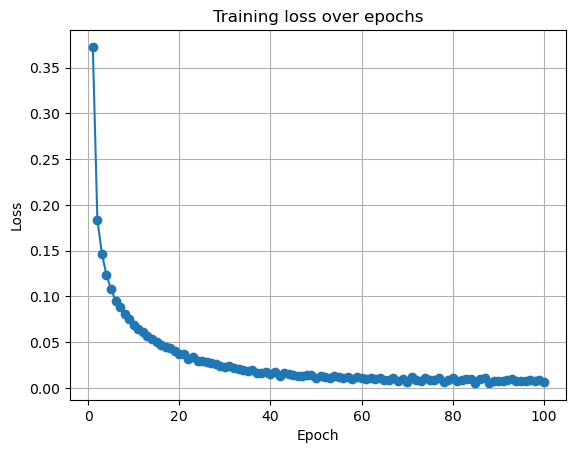

Final training accuracy: 99.45%
Training accuracy: 99.45%


In [8]:
# 1. Imports
import numpy as np
from Adam import train_ffnn, predict, accuracy  # uses your module

# 2. Load your data (example using keras; use your own loader if you already have one)
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(x_train, y_train), _ = mnist.load_data()
X_train = x_train.reshape(-1, 28*28).astype("float32") / 255.0
T_train = to_categorical(y_train, num_classes=10)

print("X_train shape:", X_train.shape)  
print("T_train shape:", T_train.shape)  

# 3. Choose optimizer via flag
USE_ADAM = True   # False -> plain gradient descent
                  # True  -> uses Adam

# 4. Define architecture
dims = [X_train.shape[1], 32, 16, T_train.shape[1]]  # [784, 32, 16, 10]

# 5. Train
W, losses = train_ffnn(
    X_train,
    T_train,
    dims,
    epochs=100,
    lr=1e-3,
    batch_size=32,
    use_adam=USE_ADAM,
    plot=True,
)

# 6. (optional) reuse W, predict, accuracy here on train/val/test sets
# Training accuracy
X_col = X_train.T          # (D, N)
T_col = T_train.T          # (C, N)
train_acc = accuracy(X_col, T_col, W) * 100
print(f"Training accuracy: {train_acc:.2f}%")


# if we have a sperate teste set:
# Suppose X_test, T_test (one-hot) are defined

# test_acc = accuracy(X_test.T, T_test.T, W) * 100
# print(f"Test accuracy: {test_acc:.2f}%")


# And to get predictions for some samples:

# y_pred = predict(X_test.T, W)   # predicted digit for each test image


